<a href="https://colab.research.google.com/github/escaduto/BuildingExtraction/blob/master/%5B1%5D_BuildingDamage_STA221_feature_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Comparative Assessment of Building Damage from High-Resolution Satellite-Based Images 

Erica Scaduto (escaduto@ucdavis.edu), Yuhan Huang (yuhhuang@ucdavis.edu)

The automatic extraction and evaluation of building damage by natural hazards can aid in assessing risk management and mapping distributions of urban vulnerability. Although wildfire is a common and critical natural disaster posing significant threats, constrained by the methods and data quality, most previous studies only focused on large-scale disasters. Deriving a reliable and efficient building extraction and damage classification method has presented challenges due to regional differences in development type (e.g. rural vs metropolitan), as well as the sheer varieties in building characteristics (i.e. color, shape, materials). In this project, we intend to compare different machine learning algorithms for image classification to develop a general framework for fire-induced building damage evaluation from high-resolution remotely sensed images.

<br>Our results show machine learning models, based on spectral, texture, and convolutional features, have promising utility in the applications for post-fire building-damage monitoring. For the binary classification scheme, the Random Forest (RF) classifier performed the best with an overall accuracy of 93% with a kappa of 0.73. For the multiclass scheme (i.e without vegetation mask), XGBoost performed better than the 5-layer neural networks. It is able to detect building areas but is less accurate in predicting damage when compared with the binary case. Feature engineering also proved to be an essential step in model building. Particularly, the addition of SNIC segmentation which greatly aided in the improvement of overall model performance for both RF and XGBoost classifiers. 

<br>Main Pipeline:
<br>**Data Preprocessing**: As both XView building annotations and NAIP images include geograohic information, XView data was converted to shapefiles to filter out corresponding NAIP images in the same location through GEE API. Both pre-fire and post-fire images were used. 
<br>**Feature Engineering:** Based on the four channels of NAIP images, features were further calculated through band math, convolutoinal filters and unsupervised methods. 
<br>**Classification Model:** Decision tree, SVM, random forest, xgboost, and simple neural networks were built to test their predictability of buliding damage types. The dicision tree, SVM, and random forest were run directly on the server provided by GEE API. XGBoost and neural net were run locally on images extracted through GEE from Google Colab. 
<br>**Model Evaluation**

## Table of Content
(1) __Preprocessing XView Data__ (See file: 0_BuildingDamage_STA221_preprocessing.ipynb): extract geographic coordinates and fire-related annotations as geojson and shapefilesfrom XView json files
<br>(2) __Set up__: Load API and packages. Connect to Google Drive, GEE API, and load annotations
<br>(3) __Visualize Dataset__: use GEE API and leaflet to visualize ground truth labels and acquire NAIP images based on the locations of these labels
<br>(4) __Vegetation Indices and Texture FEatures__: calculate several useful features for classification, including remote sensing indices, texture metrics, and some layers filtered by convolutional filters
<br>(5) __Unsupervised Clustering Features__: use unsupervised methods to get clusters, superpixels, or segmentations as features
<br>(6) __Image Extraction__: using the extent of buildings with the same image id as the boundary to extract NAIP images from the API. 
<br>(7) __Supervised Classification (server-end)__: GEE provide some fuctions for machine learning method (*Decision Tree, SVM, and Random Forest*) to do the classification directly on its server. Test these methods on the NAIP images and summarize their results
<br>(8) __Supervised Classificatoin (client-end, XGBoost)__: See notebook *BuildingProj_XGBoost*. 
<br>(9) __Supervised Classification (client-end, Simple Neural Network)__: See notebook *BuildingProj_NN*. 


## Dataset: 
- Building Annotations from XView
- NAIP (National Agriculture Imagery Program) aerial photos (resolution: 0.6 meter)

### XView Annotations
- Labels for two fire events in 2017: Santa Rosa & South CA fires  (geographic coordinates only)
![alt text](https://miro.medium.com/max/1200/1*0KCxmxuLX_CAol-xOBmG5w.jpeg)




### NAIP images (acquired from GEE API)
- RGB, Near Infrared
- both pre- and post- fire images

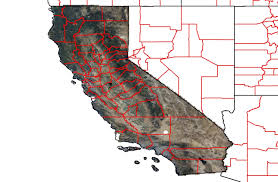

## Setting Up

The following steps below will (1) mount the colab to the appropriate drive directory (2) Load the training and tes datasets (3) connect to GEE API and load the data as GEE Assets

### Connect to Drive & Set Directory

In [ ]:
from google.colab import drive # import drive from google colab
ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT)           # we mount the google drive at /content/drive

/content/drive
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
%cd "/content/drive/My Drive/STA221_FinalProj"
%ls "./Data/FireDataset/train"

import os
rootPath = '/content/drive/My Drive/STA221_FinalProj'
os.chdir(rootPath)

/content/drive/.shortcut-targets-by-id/1xQURupjEB6eidd-IqFW8qhj4FjXXQz8r/STA221_FinalProj
santa-rosa-wildfire/  socal-fire/


### Load Data

In [ ]:
# install dependencies and packages 
! pip install geopandas

     |████████████████████████████████| 931kB 2.9MB/s 
     |████████████████████████████████| 14.7MB 299kB/s 
     |████████████████████████████████| 10.9MB 45.8MB/s 


In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd

In [ ]:
def lstFiles(rootPath, ext):
  '''
  retrieve file path + names based on extension
  '''
  file_list = []
  root = rootPath
  for path, subdirs, files in os.walk(root):
      for names in files: 
          if names.endswith(ext) and not names.startswith("._"):
              file_list.append(path  +"/" + names)
  return(file_list)

def createFolder(rootPath, folderName): 
  '''
  Create new folder in root path 
  '''
  folderPath = os.path.join(rootPath, folderName) 
  if not os.path.exists(folderPath):
      os.makedirs(folderPath)
  return folderPath + "/" 

In [ ]:
merged_path = "./Data/FireDataset/merged_shp"
merged_files = lstFiles(merged_path, '.shp')

train_shp = merged_files[0]
test_shp = merged_files[1]

In [ ]:
from pyproj import CRS

def subsetData(dataPath, path, outfolder): 
  '''(1) Subset training dataset w/Santa Rosa (post fire) & Socal (pre fire) ** since NAIP doesnt reflect post fire damage 
     (2) combine 
     (3) Remove any unclassified classes
     (4) Convert factor classes 'damage' to int (no-damage:0, minor-damage:1, destroyed:3)
     (5) output to folder in rootpath
  '''
  gdf = gpd.read_file(dataPath)
  santaRosa = gdf[(gdf['location_n'] == 'santa-rosa-wildfire') & (gdf['pre_post_d'] == 'post')] 
  socal = gdf[(gdf['location_n'] == 'socal-fire') & (gdf['pre_post_d'] == 'pre')]
  joined_all = gpd.GeoDataFrame( pd.concat( [santaRosa, socal], ignore_index=True) )
  joined_all = joined_all[(joined_all['damage'] != 'unclassified') & (joined_all['damage'] != 'un-classified')] 
  joined_all['class'] = np.where(joined_all['damage']== 'no-damage', 0,1) 
  joined_all.crs = "EPSG:4326"
  outPath = createFolder(path, outfolder)
  joined_all.to_file(os.path.join(outPath, outfolder + '.shp'))
  return joined_all

In [ ]:
path = "Data/FireDataset/merged_shp"

trainDF = subsetData(train_shp, path, 'train_filt')
testDF = subsetData(test_shp, path, 'test_filt')

In [ ]:
print(len(trainDF[trainDF['class'] == 0]), len(trainDF[trainDF['class'] == 1]),len(trainDF))
print(len(testDF[testDF['class'] == 0]), len(testDF[testDF['class'] == 1]), len(testDF))

19760 3612 23372
7494 992 8486


### Connect to GEE API & Load Asset

In [ ]:
# initialize and connect to GEE 
from google.colab import auth
auth.authenticate_user()
!earthengine authenticate
import ee 
ee.Initialize()

Instructions for updating:
non-resource variables are not supported in the long term
Running command using Cloud API.  Set --no-use_cloud_api to go back to using the API

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=D9-c3gX87rOfPDvTgEClmxOH7k0uGrHJSy5yIhw8g7Y&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/0wFo7cOCcbd2ehrBb70TeVsqL5OStlVImYGpxHQhb500ubIkhh58WlM

Successfully saved authorization token.


In [ ]:
# Installs geemap package
import subprocess

try:
    import geemap
except ImportError:
    print('geemap package not installed. Installing ...')
    subprocess.check_call(["python", '-m', 'pip', 'install', 'geemap'])

# Checks whether this notebook is running on Google Colab
try:
    import google.colab
    import geemap.eefolium as emap
except:
    import geemap as emap

geemap package not installed. Installing ...


In [ ]:
# Connect to google cloud 
! gcloud auth login

In [ ]:
# export files hosted in cloud bucket as assets to GEE 
# needed to set up a bucket in google cloud: gs://esca_bucket
! earthengine upload table --asset_id=users/escaduto/XVIEW_newtraining gs://esca_bucket/train_filt/train_filt.shp
! earthengine upload table --asset_id=users/escaduto/XVIEW_newtesting gs://esca_bucket/test_filt/test_filt.shp

In [ ]:
# import feature collection asset 
train_data = ee.FeatureCollection('users/escaduto/XVIEW_newtraining')
test_data = ee.FeatureCollection('users/escaduto/XVIEW_newtesting')

## Interactively Visualize Dataset w/ GEE API & leaflet

The annotated test/train xView dataset were read as feature collections via the GEE API. Now, we want to visualize the building footprints and identify which ones are classified as damaged vs non-damaged. To best do this, we will utilize an interactive mapping tool to directly load the data into the notebook.

### Building Geometry w/ Attributes

In [ ]:
def visualizeByAttribute(fc, className): 
  '''
  visualize building polygon based on damage type 'class' (0,1) 
  '''   
  empty = ee.Image().byte()
  feature = empty.paint(**{
    'featureCollection': fc,
    'color': className,
    'width': 1
  })
  return feature

train_palette = ['green', # no-damage (0)
                 'red' # destroyed (1) 
                 ]
test_palette = ['yellow', # no-damage(0)
                'blue' # destroyed (1) 
                ]

Map = emap.Map(center=[38.50178453635526,-122.74843617724784], zoom=16)
Map.addLayer(visualizeByAttribute(train_data, 'class'), {'palette': train_palette, 'min': 0, 'max':1}, 'train')
Map.addLayer(visualizeByAttribute(test_data, 'class'), {'palette': test_palette,'min': 0, 'max':1}, 'test')
Map.addLayerControl()
Map

## Load NAIP Imagery

Another crucial step before we can get started is to load the NAIP imagery from GEE. To first do this, we must identify our area of interest, which is the bounding box from the data extent. We will obtain pre-/post- fire imagery and overlay the annotated building footprints on top.

In [ ]:
def extract_coords(geom):
    '''
    takes one polygon from geopandas and converts it to the GEE geometry format
    input: geom from each row of the 'geometry' column in the gpd dataframe 
    output: coordinate list of the GEE geometry
    '''
    try:
        coords=geom.__geo_interface__['coordinates']
        geom_extr=[list(map(list,coord)) for coord in coords]
        return geom_extr
    except:
        pass

def get_bounds(gdf):
    '''
    takes a geo data frame get convert its bounding extent to a GEE format rectangle
    '''
    bounds=gdf.total_bounds
    geom_bound=[[ [bounds[0],bounds[1]], [bounds[2],bounds[1]], [bounds[2],bounds[3]], [bounds[0],bounds[3]]]]
    return geom_bound

In [ ]:
gdf = gpd.read_file(train_shp)
santaRosa = gdf[(gdf['location_n'] == 'santa-rosa-wildfire') & (gdf['pre_post_d'] == 'post')] 
socal = gdf[(gdf['location_n'] == 'socal-fire') & (gdf['pre_post_d'] == 'pre')]

SR_bounds=get_bounds(santaRosa)
SC_bounds=get_bounds(socal)

In [ ]:
sr_geom=[extract_coords(pol) for pol in santaRosa['geometry']]
SR_ROI = ee.Geometry.MultiPolygon(sr_geom)
SR_Bound_Box=ee.Geometry.Polygon(SR_bounds)

sc_geom=[extract_coords(pol) for pol in socal['geometry']]
SC_ROI = ee.Geometry.MultiPolygon(sc_geom)
SC_Bound_Box=ee.Geometry.Polygon(SC_bounds)

In [ ]:
# combine the bounding boxes from above into feature collection
features = [
  ee.Feature(SC_Bound_Box),
  ee.Feature(SR_Bound_Box)
]

finalBounds = ee.FeatureCollection(features);

In [ ]:
preFire = ee.Image(ee.ImageCollection('USDA/NAIP/DOQQ')
                  .filter(ee.Filter.date('2014-01-01', '2015-12-31'))
                  .select(['R', 'G', 'B', 'N'])
                  .filterBounds(finalBounds)
                  .mosaic());
                  
postFire = ee.Image(ee.ImageCollection('USDA/NAIP/DOQQ')
                  .filter(ee.Filter.date('2017-01-01', '2019-12-31'))
                  .select(['R', 'G', 'B', 'N'])
                  .filterBounds(finalBounds)
                  .mosaic());

preFire = preFire.clip(finalBounds)
postFire = postFire.clip(finalBounds)

trueColorVis = {
  min: 0.0,
  max: 255.0,
}

In [ ]:
# visualize santa rosa building dataset overlaid on NAIP
Map = emap.Map(center=[38.4815,-122.7084], zoom=11)
Map.add_basemap('TERRAIN')
Map.addLayer(preFire.select(['R', 'G', 'B']), trueColorVis, 'PreFire')
Map.addLayer(postFire.select(['R', 'G', 'B']), trueColorVis, 'Postfire')
Map.addLayer(finalBounds, {'color': 'white'}, 'bound', True, opacity=0.4)
Map.addLayer(visualizeByAttribute(train_data, 'class'), {'palette': train_palette, 'min': 0, 'max':1}, 'train')
Map.addLayer(visualizeByAttribute(test_data, 'class'), {'palette': test_palette,'min': 0, 'max':1}, 'test')
Map.addLayerControl()
Map

In [ ]:
# visualize socal building dataset overlaid on NAIP
Map = emap.Map(center=[34.0922,-118.8058], zoom=11)
Map.add_basemap('TERRAIN')
Map.addLayer(preFire, trueColorVis, 'PreFire');
Map.addLayer(postFire, trueColorVis, 'Postfire');
Map.addLayer(finalBounds, {'color': 'white'}, 'Postfire', True, opacity = 0.8);
Map.addLayer(visualizeByAttribute(train_data, 'class'), {'palette': train_palette, 'min': 0, 'max':1}, 'train')
Map.addLayer(visualizeByAttribute(test_data, 'class'), {'palette': test_palette,'min': 0, 'max':1}, 'test')
Map.addLayerControl()
Map

## Feature Calculation

(1) NDVI: (NIR-R)/(NIR+R)

(2) Canny edge detection to extract structural information from different vision objects and dramatically reduce the amount of data to be processed. 

(3) Bare Soil Index: (R+B-G)/(R+G+B)

(4) Shadow Index: $\sqrt {(256-B)*(256-G)}$

(5) Texture Information: GLCM & spatial association of neighborhood

(6)  Convolutional filters

###NDVI

In [ ]:
def getNDVI(image):
  '''
  Add Normalized Differenced Vegetation Index using NIR and Red bands
  '''
  nir = image.select('N')
  red = image.select('R')
  ndvi = nir.subtract(red).divide(nir.add(red)).rename('NDVI')
  new_image = image.addBands(ndvi)
  return new_image

preFire = getNDVI(preFire)
postFire = getNDVI(postFire)
print(preFire.bandNames().getInfo())

['R', 'G', 'B', 'N', 'NDVI']


### Edge Detection

In [ ]:
def edgeDetection(image, band):
  '''
  Perform Canny edge detection and add to image.
  '''
  canny = ee.Algorithms.CannyEdgeDetector(**{
    'image': image.select(band), 'threshold': 50, 'sigma': 1
  })
  new_image = image.addBands(canny.rename('edge'))
  return new_image


preFire = edgeDetection(preFire, 'R')
postFire = edgeDetection(postFire, 'R')
print(preFire.bandNames().getInfo())


['R', 'G', 'B', 'N', 'NDVI', 'edge']


### Bare Soil Index (BSI)

In [ ]:
def bareSoil(image):
  '''
  Add Bare Soil Index Index using the Red, Blue, and Green bands
  '''
  red = image.select('R')
  blue = image.select('B')
  green = image.select('G')
  BSI = red.add(blue).subtract(green).divide(red.add(blue).add(green)).rename('BSI')
  new_image = image.addBands(BSI)
  return new_image

preFire = bareSoil(preFire)
postFire = bareSoil(postFire)
print(preFire.bandNames().getInfo())

['R', 'G', 'B', 'N', 'NDVI', 'edge', 'BSI']


### Shadow Index

In [ ]:
def shadowIndex(image):
  '''
  Add Shadow Index using Blue and Green bands
  '''
  SI = image.expression(
      'sqrt((256 - B) * (256 - G))', {
        'B': image.select('B'),
        'G': image.select('G')
  }).rename('SI');
  new_image = image.addBands(SI)
  return new_image

preFire = shadowIndex(preFire)
postFire = shadowIndex(postFire)
print(preFire.bandNames().getInfo())

['R', 'G', 'B', 'N', 'NDVI', 'edge', 'BSI', 'SI']


### Texture
Get texture values with NIR band. 
  (1) compute entropy w. defined neighborhood, 
  (2) gray-level co-occurence matrix (GLCM) to get contrast,
  (3) local Geary's C, measure of spatial association

[  source code](https://github.com/giswqs/earthengine-py-notebooks/blob/master/Image/texture.ipynb)

In [ ]:
import math

def texture(image):
  ''' 
  Get texture values with NIR band. 
  (1) compute entropy w. defined neighborhood, 
  (2) gray-level co-occurence matrix (GLCM) to get contrast,
  (3) local Geary's C, measure of spatial association
  '''
  # Get the NIR band.
  nir = image.select('N')
  # Define a neighborhood with a kernel.
  square = ee.Kernel.square(**{'radius': 4})
  # Compute entropy and display.
  entropy = nir.entropy(square)
  # Compute the gray-level co-occurrence matrix (GLCM), get contrast.
  glcm = nir.glcmTexture(**{'size': 4})
  contrast = glcm.select('N_contrast')
  # Create a list of weights for a 9x9 kernel.
  list = [1, 1, 1, 1, 1, 1, 1, 1, 1]
  # The center of the kernel is zero.
  centerList = [1, 1, 1, 1, 0, 1, 1, 1, 1]
  # Assemble a list of lists: the 9x9 kernel weights as a 2-D matrix.
  lists = [list, list, list, list, centerList, list, list, list, list]
  # Create the kernel from the weights.
  # Non-zero weights represent the spatial neighborhood.
  kernel = ee.Kernel.fixed(9, 9, lists, -4, -4, False)

  # Convert the neighborhood into multiple bands.
  neighs = nir.neighborhoodToBands(kernel)

  # Compute local Geary's C, a measure of spatial association.
  gearys = nir.subtract(neighs).pow(2).reduce(ee.Reducer.sum()) \
             .divide(math.pow(9, 2)).rename('texture');
  new_image = image.addBands(gearys)
  return new_image

preFire = texture(preFire)
postFire = texture(postFire)
print(preFire.bandNames().getInfo())

['R', 'G', 'B', 'N', 'NDVI', 'edge', 'BSI', 'SI', 'texture']


### GLCM Texture

GLCM Texture list (selection in bold):
- Angular Second Moment: # of repeated pairs
- **Contrast**: local contrast 
- **Correlation**: correlation between pairs of pixels 
- **Variance**: spreat-out of the Grayscale 
-**Inverse Difference Moment**: homogeneity
- sum average
- sum variance
- sum entropy
- entropy: randomness of the grayscale
- difference variance
- difference entropy
- information measure of correlation 1, 2 , and Max Corr. Coefficient.
- **dissimilarity**
- inertia
- **cluster shade**
- cluster prominence

In [ ]:
def glcm_texture(image):
    '''
    add some texture calculations for each spectral band (contrast and variance only for NIR and Red band)
    '''
    #average the directional bands
    #consider a neighborhood of 4 pixels
    texture_img=image.select(['R','G','B','N']).glcmTexture(size=4,average=True)
    #select some useful textures :
    selection=['N_corr','N_var', 'B_shade','N_shade']
    new_image = image.addBands(texture_img.select(selection))
    return new_image

In [ ]:
preFire = glcm_texture(preFire)
postFire = glcm_texture(postFire)
print(preFire.bandNames().getInfo())

['R', 'G', 'B', 'N', 'NDVI', 'edge', 'BSI', 'SI', 'texture', 'N_corr', 'N_var', 'B_shade', 'N_shade']


### Convolution Layers

(tuned with best visual performance)
- low-pass convolutional filter (Gaussian)
- high-pass filter and gradient (has been represented by canny edge detection above)
- shape-sensitive filter (rectangle, octagon)
- manhattan kernel based on rectilinear (city-block) distance

In [ ]:
def conv_filter(image):
    '''
    apply gaussian, octagon, and mangattan convolutional filters to the image
    '''
    #define filters
    #Gaussian
    gauss=ee.Kernel.gaussian(radius=7, sigma=2, units='pixels', normalize=True)
    # #define a 19 by 11 rectangle low pass filter
    # low_pass_rect1 = ee.Kernel.rectangle(xRadius=9,yRadius=5, units='pixels', normalize=True);
    # #the opposite way
    # low_pass_rect2 = ee.Kernel.rectangle(xRadius=5,yRadius=9, units='pixels', normalize=True);
    #octagon
    low_oct = ee.Kernel.octagon(radius=5, units='pixels', normalize=True);
    #manhattan
    manha=ee.Kernel.manhattan(radius=4, units='pixels', normalize=True)
    new_image=image
    filt_dict={'gauss':gauss,'low_oct':low_oct,'manha':manha}
    for name,filt in filt_dict.items():
        smooth=image.select(['R','G','B','N']).convolve(filt).rename(['R_'+name,'G_'+name,'B_'+name,'N_'+name])
        new_image = new_image.addBands(smooth)
    return new_image

In [ ]:
preFire = conv_filter(preFire)
postFire = conv_filter(postFire)
print(preFire.bandNames().getInfo())

['R', 'G', 'B', 'N', 'NDVI', 'edge', 'BSI', 'SI', 'texture', 'N_corr', 'N_var', 'B_shade', 'N_shade', 'R_gauss', 'G_gauss', 'B_gauss', 'N_gauss', 'R_low_oct', 'G_low_oct', 'B_low_oct', 'N_low_oct', 'R_manha', 'G_manha', 'B_manha', 'N_manha']


### Visualize Indices

In [ ]:
siViz = {'min': 0, 'max': 100, 'palette': ['ffff00', '330033']}
bsiViz = {'min': 0.0, 'max': 0.3, 'palette': ['7fffd4', 'b99879']}
ndviViz = {'min': -0.5, 'max': 0.5, 'palette': ['cc8e7f', '268b07']}
texViz = {'min': 0, 'max': 4000, 'palette': ['fe6b73', '7fffd4']}

Map = emap.Map(center=[38.50178453635526,-122.74843617724784], zoom=16)
Map.addLayer(preFire.select(['R', 'G', 'B']), trueColorVis, 'preFire')
Map.addLayer(preFire.select(['NDVI']),ndviViz, 'NDVI')
Map.addLayer(preFire.select(['SI']),siViz, 'SI')
Map.addLayer(preFire.select(['edge']),'', 'Canny')
Map.addLayer(preFire.select(['BSI']),bsiViz, 'BSI')
Map.addLayer(preFire.select(['texture']),texViz, 'texture')
Map.addLayer(train_data, {'color': 'yellow'}, 'training')
Map.addLayer(test_data, {'color': 'blue'}, 'testing')
Map.addLayerControl()
Map

## Unsupervised Methods

(1) KMeans Clustering

(2) Learning Vector Quantization Clustering (LVQ)

(3) KMeans Segmentation 

(4) Simple Non-Iterative Clustering Segmentation (SNIC)

### KMeans Clustering

In [ ]:
bands = ['R', 'G', 'B', 'N', 'NDVI', 'edge', 'BSI', 'SI', 'texture']
# Make the training dataset.
training = postFire.sample(**{
  'region': finalBounds,
  'scale': 10,
  'numPixels': 5000
})

# Instantiate the clusterer and train it.
clusterer = ee.Clusterer.wekaKMeans(15).train(training)

# Cluster the input using the trained clusterer.
preFire_result = preFire.cluster(clusterer).rename('KMeans')
postFire_result = postFire.cluster(clusterer).rename('KMeans')

In [ ]:
# add KMeans clustering 
postFire = postFire.addBands(postFire_result)
preFire = preFire.addBands(preFire_result)
print(postFire.bandNames().getInfo())

['R', 'G', 'B', 'N', 'NDVI', 'edge', 'BSI', 'SI', 'texture', 'N_corr', 'N_var', 'B_shade', 'N_shade', 'R_gauss', 'G_gauss', 'B_gauss', 'N_gauss', 'R_low_oct', 'G_low_oct', 'B_low_oct', 'N_low_oct', 'R_manha', 'G_manha', 'B_manha', 'N_manha', 'LVQ', 'KMeans']


In [ ]:
Map = emap.Map(center=[38.50178453635526,-122.74843617724784], zoom=19)
Map.addLayer(preFire.select(['R', 'G', 'B']), trueColorVis, 'preFire')
Map.addLayer(postFire.select(['R', 'G', 'B']), trueColorVis, 'postFire')
Map.addLayer(postFire_result.randomVisualizer(),'', 'postFire_Kmeans',opacity=0.6)
Map.addLayer(preFire_result.randomVisualizer(),'', 'preFire_Kmeans', opacity=0.6)
Map.addLayer(train_data, {'color': 'yellow'}, 'training',opacity=0.4)
Map.addLayer(test_data, {'color': 'blue'}, 'testing',opacity=0.4)
Map.addLayerControl()
Map

###Learning Vector Quantization (LVQ) Clustering

T. Kohonen, "Learning Vector Quantization", The Handbook of Brain Theory and Neural Networks, 2nd Edition, MIT Press, 2003, pp. 631-634.

**ee.Clusterer.wekaLVQ(numClusters, learningRate, epochs, normalizeInput)**

In [ ]:
bands = ['R', 'G', 'B', 'N', 'NDVI', 'edge', 'BSI', 'SI', 'texture']

# Make the training dataset.
training = postFire.select(bands).sample(**{
  'region': finalBounds,
  'scale': 10,
  'numPixels': 5000
})

# Instantiate the clusterer and train it.
clusterer = ee.Clusterer.wekaLVQ(15).train(training)

# Cluster the input using the trained clusterer.
preFire_result = preFire.select(bands).cluster(clusterer).rename('LVQ')
postFire_result = postFire.select(bands).cluster(clusterer).rename('LVQ')

In [ ]:
# add layer
postFire = postFire.addBands(postFire_result)
preFire = preFire.addBands(preFire_result)
print(postFire.bandNames().getInfo())

['R', 'G', 'B', 'N', 'NDVI', 'edge', 'BSI', 'SI', 'texture', 'N_corr', 'N_var', 'B_shade', 'N_shade', 'R_gauss', 'G_gauss', 'B_gauss', 'N_gauss', 'R_low_oct', 'G_low_oct', 'B_low_oct', 'N_low_oct', 'R_manha', 'G_manha', 'B_manha', 'N_manha', 'LVQ']


In [ ]:
Map = emap.Map(center=[38.50178453635526,-122.74843617724784], zoom=18)
Map.addLayer(postFire.select(['R', 'G', 'B']), trueColorVis, 'postFire')
Map.addLayer(postFire_result.randomVisualizer(),'', 'postFire_LVQ',opacity=0.6)
Map.addLayer(preFire_result.randomVisualizer(),'', 'preFire_LVQ', opacity=0.6)
Map.addLayer(train_data, {'color': 'yellow'}, 'training',opacity=0.4)
Map.addLayer(test_data, {'color': 'blue'}, 'testing',opacity=0.4)
Map.addLayerControl()
Map

###  KMeans Segmentation

**Description:** Performs K-Means clustering on the input image. Outputs a 1-band image containing the ID of the cluster that each pixel belongs to.

<br> 
**ee.Algorithms.Image.Segmentation.KMeans(image, numClusters, numIterations, neighborhoodSize, gridSize, forceConvergence, uniqueLabels)**


*   **numClusters:** Number of clusters.
*   **numIterations:** Number of iterations.
*   **neighborhoodSize:** The amount to extend each tile (overlap) when computing the clusters. This option is mutually exclusive with gridSize.
*   **gridSize:** If greater than 0, kMeans will be run independently on cells of this size. This has the effect of limiting the size of any cluster to be gridSize or smaller. This option is mutually exclusive with neighborhoodSize.
*   **forceConvergence:** If true, an error is thrown if convergence is not achieved before numIterations.
*   **uniqueLabels:** If true, clusters are assigned unique IDs. Otherwise, they repeat per tile or grid cell.

In [ ]:
pre_kmeans = ee.Algorithms.Image.Segmentation.KMeans(preFire, 15, 1000, 20, 0, False, False)
pre_clusters = pre_kmeans.select('clusters').rename('KMeans_Seg')

post_kmeans = ee.Algorithms.Image.Segmentation.KMeans(postFire, 15, 1000, 20,0, False, False)
post_clusters = post_kmeans.select('clusters').rename('KMeans_Seg')

In [ ]:
# add layer
postFire = postFire.addBands(post_clusters)
preFire = preFire.addBands(pre_clusters)
print(preFire.bandNames().getInfo())

['R', 'G', 'B', 'N', 'NDVI', 'edge', 'BSI', 'SI', 'texture', 'N_corr', 'N_var', 'B_shade', 'N_shade', 'R_gauss', 'G_gauss', 'B_gauss', 'N_gauss', 'R_low_oct', 'G_low_oct', 'B_low_oct', 'N_low_oct', 'R_manha', 'G_manha', 'B_manha', 'N_manha', 'LVQ', 'KMeans', 'KMeans_Seg']


In [ ]:
Map = emap.Map(center=[38.50178453635526,-122.74843617724784], zoom=18)
Map.addLayer(preFire.select(['R', 'G', 'B']), trueColorVis, 'preFire')
Map.addLayer(postFire.select(['R', 'G', 'B']), trueColorVis, 'postFire')
Map.addLayer(pre_clusters.randomVisualizer(),'', 'pre_clusters', opacity=0.6)
Map.addLayer(post_clusters.randomVisualizer(),'', 'post_clusters', opacity=0.6)
Map.addLayer(train_data, {'color': 'yellow'}, 'training',opacity=0.4)
Map.addLayer(test_data, {'color': 'blue'}, 'testing',opacity=0.4)
Map.addLayerControl()
Map

### Simple Non-Iterative Clustering (SNIC) Segmentation

**Description:** An improved version of non-parametric SLIC. Superpixel clustering based on SNIC (Simple Non-Iterative Clustering). Outputs a band of cluster IDs and the per-cluster averages for each of the input bands. Outputs a band of cluster IDs and the per-cluster averages for each of the input bands.

<br>

**ee.Algorithms.Image.Segmentation.SNIC(image, size, compactness, connectivity, neighborhoodSize, seeds)**

*   **size:** The superpixel seed location spacing, in pixels. If 'seeds' image is provided, no grid is produced.
*   **compactness:** Compactness factor. Larger values cause clusters to be more compact (square). Setting this to 0 disables spatial distance weighting.
*   **connectivity:** Connectivity. Either 4 or 8.
*   **neighbor:** Tile neighborhood size (to avoid tile boundary artifacts). Defaults to 2 * size.
*   **seeds:** If provided, any non-zero valued pixels are used as seed locations. Pixels that touch (as specified by 'connectivity') are considered to belong to the same cluster.




In [ ]:
def expandSeeds(seeds): 
  seeds = seeds.unmask(0).focal_max()
  return seeds.updateMask(seeds)

In [ ]:
seeds = ee.Algorithms.Image.Segmentation.seedGrid(30)

pre_snic = ee.Algorithms.Image.Segmentation.SNIC(preFire, 30, 15, 8, 200, seeds).select(["R_mean", "G_mean", "B_mean", "N_mean", "clusters"], ["R", "G", "B", "N", "clusters"])
pre_clusters = pre_snic.select('clusters').rename('SNIC')

post_snic = ee.Algorithms.Image.Segmentation.SNIC(postFire, 30, 15, 8)
post_clusters = post_snic.select('clusters').rename('SNIC')

In [ ]:
# add layer
postFire = postFire.addBands(post_clusters)
preFire = preFire.addBands(pre_clusters)
print(preFire.bandNames().getInfo())

['R', 'G', 'B', 'N', 'NDVI', 'edge', 'BSI', 'SI', 'texture', 'N_corr', 'N_var', 'B_shade', 'N_shade', 'R_gauss', 'G_gauss', 'B_gauss', 'N_gauss', 'R_low_oct', 'G_low_oct', 'B_low_oct', 'N_low_oct', 'R_manha', 'G_manha', 'B_manha', 'N_manha', 'LVQ', 'KMeans', 'KMeans_Seg', 'SNIC']


In [ ]:
Map = emap.Map(center=[38.50178453635526,-122.74843617724784], zoom=18)
Map.addLayer(pre_clusters.randomVisualizer(),'' , "clusters")
Map.addLayer(post_clusters.randomVisualizer(),'', 'postFire_SNIC', opacity=0.6)
Map.addLayer(expandSeeds(seeds), {}, 'seeds')
Map.addLayer(train_data, {'color': 'yellow'}, 'training',opacity=0.4)
Map.addLayer(test_data, {'color': 'blue'}, 'testing',opacity=0.4)
Map.addLayerControl()
Map

## Filter Imagery

Exclude areas with vegetation i.e. only keeps imagery areas with urban and baresoil 

In [ ]:
hansenImage = ee.Image('UMD/hansen/global_forest_change_2015')

def applyMask(imageryA, imageryB, hansenImage):
  '''
  Mask out all vegetation and water from imagery from pre disaster values.
  '''
  NDVIMaskB = imageryB.select('NDVI').lt(0.005)
  dataMask =  hansenImage.select('datamask')
  waterMask = dataMask.eq(1)
  imageryA = imageryA.updateMask(NDVIMaskB)
  new_imagery = imageryA.updateMask(waterMask)
  return new_imagery

postFire_filt = applyMask(postFire, preFire, hansenImage)

In [ ]:
Map = emap.Map(center=[38.50178453635526,-122.74843617724784], zoom=11)
Map.addLayer(postFire_filt.select(['R', 'G', 'B']), trueColorVis, 'postFire')
Map.addLayerControl()
Map

## Supervised Classification

(1) Train Data

(2) CART 

(3) SVM

(4) Random Forest


### Train Data

In [ ]:
# get layer names 
print(postFire_filt.bandNames().getInfo())

['R', 'G', 'B', 'N', 'NDVI', 'edge', 'BSI', 'SI', 'texture', 'N_corr', 'N_var', 'B_shade', 'N_shade', 'R_gauss', 'G_gauss', 'B_gauss', 'N_gauss', 'R_low_oct', 'G_low_oct', 'B_low_oct', 'N_low_oct', 'R_manha', 'G_manha', 'B_manha', 'N_manha', 'LVQ', 'KMeans', 'KMeans_Seg', 'SNIC']


In [ ]:
bands = ['R', 'G', 'B', 'N', 'NDVI', 'BSI',  # Bands & Indices
         'SNIC', # Clustering, Segmentation
         'N_corr', 'B_shade', 'B_gauss', # GLCM Texture
         'R_manha','R_low_oct'] # Convolution 
training = postFire_filt.select(bands).sampleRegions(**{
  'collection': train_data,
  'properties': ['class'],
  'scale': 10
});

### CART

#### Classifier

In [ ]:
# Train a CART classifier with default parameters.
classifier = ee.Classifier.smileCart().train(training, 'class', bands);

# Classify the image with the same bands used for training.
postFire_classified = postFire_filt.select(bands).classify(classifier);
#preFire_classified = preFire_filt.select(bands).classify(trained);

#### Feature Importance

In [ ]:
class_explain = classifier.explain()
variable_importance = ee.Feature(None, ee.Dictionary(class_explain).get('importance'))
variable_importance.getInfo()

{'geometry': None,
 'properties': {'B': 10.748482429268728,
  'BSI': 9.048169912157672,
  'B_gauss': 5.455427147196852,
  'B_shade': 7.068837282425471,
  'G': 13.230428780308069,
  'N': 10.53676402984156,
  'NDVI': 8.063338542883878,
  'N_corr': 7.207145088380324,
  'R': 38.042603516187626,
  'R_low_oct': 1.176300702671833,
  'R_manha': 5.060776101651469,
  'SNIC': 9.711472453324498},
 'type': 'Feature'}

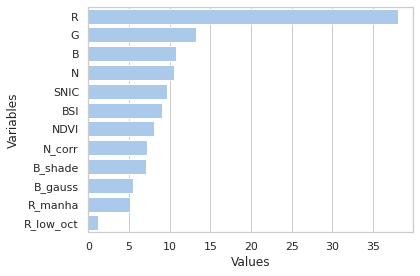

In [ ]:
import json
import matplotlib.pylab as plt
import seaborn as sns 
import pandas.util.testing as tm
sns.set(style="whitegrid")
sns.set_color_codes("pastel")

var_dict = variable_importance.getInfo()

lists = sorted(var_dict['properties'].items(), key = lambda kv:(kv[1], kv[0]), reverse=True)
var = [i[0] for i in lists]
values = [i[1] for i in lists]
d = pd.DataFrame({'Variables':var,'Values':values})

sns.barplot('Values', 'Variables', data = d, label="Variables", color="b")
plt.tight_layout()
plt.savefig("Figures/CART_feature_imp.png", dpi=250)

####Validation

In [ ]:
validation = postFire_classified.sampleRegions(**{
  'collection': test_data,
  'properties': ['class'],
  'scale': 10,
})

testAccuracy = validation.errorMatrix('class', 'classification');

In [ ]:
print("Test Accuracy: ", testAccuracy.accuracy().getInfo())
print("Kappa Accuracy: ", testAccuracy.kappa().getInfo())
print("Producer Accuracy: ", testAccuracy.producersAccuracy().getInfo())
print("Consumers Accuracy(): ", testAccuracy.consumersAccuracy().getInfo())

Test Accuracy:  0.8306339904102291
Kappa Accuracy:  0.4481339614555388
Producer Accuracy:  [[0.857304146020197], [0.6802263883975946]]
Consumers Accuracy():  [[0.9379632171287401, 0.45807527393997144]]


#### Classification Visual

In [ ]:
class_palette = ['bff7ff','ff9900']

Map = emap.Map(center=[38.50178453635526,-122.74843617724784], zoom=11)
Map.addLayer(preFire.select(['R', 'G', 'B']), trueColorVis, 'preFire')
Map.addLayer(postFire.select(['R', 'G', 'B']), trueColorVis, 'postFire')
Map.addLayer(postFire_classified,
             {'palette': class_palette, 'min': 0, 'max':1},
             'postFire_classification')
Map.addLayer(visualizeByAttribute(train_data, 'class'), {'palette': train_palette, 'min': 0, 'max':1}, 'train')
Map.addLayer(visualizeByAttribute(test_data, 'class'), {'palette': train_palette,'min': 0, 'max':1}, 'test')
Map.addLayerControl()
Map

### Support Vector Machine

#### Classifier

In [ ]:
# Create an SVM classifier with custom parameters.
classifier = ee.Classifier.libsvm(**{
  'kernelType': 'RBF'
}).train(training, 'class', bands)

# Classify the image.
postFire_classified = postFire_filt.select(bands).classify(classifier)

#### Validation

In [ ]:
validation = postFire_classified.sampleRegions(**{
  'collection': test_data,
  'properties': ['class'],
  'scale': 10,
})

testAccuracy = validation.errorMatrix('class', 'classification');

In [ ]:
print("Test Accuracy: ", testAccuracy.accuracy().getInfo())
print("Kappa Accuracy: ", testAccuracy.kappa().getInfo())
print("Producer Accuracy: ", testAccuracy.producersAccuracy().getInfo())
print("Consumers Accuracy(): ", testAccuracy.consumersAccuracy().getInfo())

Test Accuracy:  0.9042834479111581
Kappa Accuracy:  0.5850923650769214
Producer Accuracy:  [[0.9904336734693877], [0.48606811145510836]]
Consumers Accuracy():  [[0.9034322280395579, 0.9127906976744186]]


#### Classification Visual

In [ ]:
Map = emap.Map(center=[38.50178453635526,-122.74843617724784], zoom=11)
Map.addLayer(preFire.select(['R', 'G', 'B']), trueColorVis, 'preFire')
Map.addLayer(postFire.select(['R', 'G', 'B']), trueColorVis, 'postFire')
Map.addLayer(postFire_classified,
             {'palette': class_palette, 'min': 0, 'max':1},
             'postFire_classification')
Map.addLayer(visualizeByAttribute(train_data, 'class'), {'palette': train_palette, 'min': 0, 'max':1}, 'train')
Map.addLayer(visualizeByAttribute(test_data, 'class'), {'palette': train_palette,'min': 0, 'max':1}, 'test')
Map.addLayerControl()
Map

### Random Forest

ee.Classifier.randomForest(numberOfTrees, variablesPerSplit, minLeafPopulation, bagFraction, outOfBagMode, seed)


#### Classifier

In [ ]:
# Create an SVM classifier with custom parameters.
classifier = ee.Classifier.smileRandomForest(**{
  'numberOfTrees': 100
}).train(training, 'class', bands)

postFire_classified = postFire_filt.select(bands).classify(classifier)

#### Feature Importance

In [ ]:
class_explain = classifier.explain()
variable_importance = ee.Feature(None, ee.Dictionary(class_explain).get('importance'))
variable_importance.getInfo()

{'geometry': None,
 'properties': {'B': 3051.4262024613963,
  'BSI': 3478.51524258973,
  'B_gauss': 3405.550147364182,
  'B_shade': 3452.496960129187,
  'G': 2710.7155140881073,
  'N': 2861.569909222751,
  'NDVI': 3296.9396011646686,
  'N_corr': 3313.7550618749647,
  'R': 2951.1014238023768,
  'R_low_oct': 3232.513971385376,
  'R_manha': 3247.497763377401,
  'SNIC': 3685.8937357707},
 'type': 'Feature'}

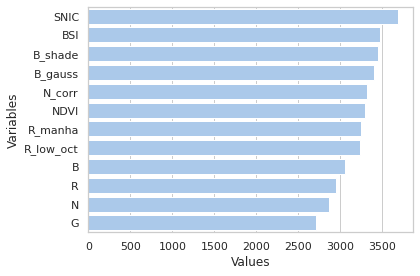

In [ ]:
sns.set(style="whitegrid")
sns.set_color_codes("pastel")

var_dict = variable_importance.getInfo()

lists = sorted(var_dict['properties'].items(), key = lambda kv:(kv[1], kv[0]), reverse=True)
var = [i[0] for i in lists]
values = [i[1] for i in lists]
d = pd.DataFrame({'Variables':var,'Values':values})

sns.barplot('Values', 'Variables', data = d, label="Variables", color="b")
plt.tight_layout()
plt.savefig("Figures/RF_feature_imp.png", dpi=250)

####Validation

In [ ]:
validation = postFire_classified.sampleRegions(**{
  'collection': test_data,
  'properties': ['class'],
  'scale': 30,
})

testAccuracy = validation.errorMatrix('class', 'classification');

In [ ]:
testAccuracy.array().getInfo()

[[1537, 31], [106, 217]]

In [ ]:
print("Test Accuracy: ", testAccuracy.accuracy().getInfo())
print("Kappa Accuracy: ", testAccuracy.kappa().getInfo())
print("Producer Accuracy: ", testAccuracy.producersAccuracy().getInfo())
print("Consumers Accuracy(): ", testAccuracy.consumersAccuracy().getInfo())

Test Accuracy:  0.8968799576943416
Kappa Accuracy:  0.5866842718202837
Producer Accuracy:  [[0.96875], [0.5479876160990712]]
Consumers Accuracy():  [[0.9123123123123124, 0.7831858407079646]]


In [ ]:
accuracy = [] 
kappa = [] 
producer = [] 
consumer = [] 
scale = [] 

for i in range (10, 120+1, 10): 
  print(i)
  validation = postFire_classified.sampleRegions(**{
    'collection': test_data,
    'properties': ['class'],
    'scale': i,
  })
  testAccuracy = validation.errorMatrix('class', 'classification')
  accuracy.append(testAccuracy.accuracy().getInfo())
  kappa.append(testAccuracy.kappa().getInfo())
  producer.append(testAccuracy.producersAccuracy().getInfo())
  consumer.append(testAccuracy.consumersAccuracy().getInfo())
  scale.append(i)

5


In [ ]:
prod_0 = [i[0] for i in producer]
prod_0 = [i[0] for i in prod_0]

prod_1 = [i[1] for i in producer]
prod_1 = [i[0] for i in prod_1]

user_0 = [i[0] for i in consumer]
user_0 = [i[0] for i in user_0]

user_1 = [i[0] for i in consumer]
user_1 = [i[1] for i in user_1]

In [ ]:
# plot effects of block scales on accuracy assessment 
data = {'Scale (pixels)': scale, 
        'Accuracy (%)': accuracy, 
        'Kappa (%)': kappa,
        'Producer (no-damage)': prod_0,
        'Producer (damaged)': prod_1,
        'User (no-damage)': user_0,
        'User (damaged)': user_1,
        }
scale_scores = pd.DataFrame.from_dict(data)

In [ ]:
#scale_scores.to_csv('scale_scores.csv', index=False)
scale_scores = pd.read_csv(r'scale_scores.csv', index_col=None)
scale_scores = scale_scores[1:]
scale_scores

In [ ]:
melted = pd.melt(scale_scores, id_vars=['Scale (pixels)'],
        value_vars=['Accuracy (%)', 'Kappa (%)',
       'Producer (damaged)', 'User (damaged)'],
       var_name='Assessment', value_name='Accuracy (%)')
melted['Accuracy (%)'] = melted['Accuracy (%)'] * 100
melted

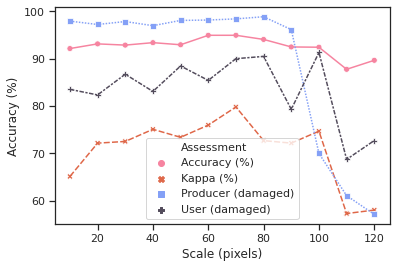

In [ ]:
import seaborn as sns
import matplotlib.pylab as plt
sns.set(style="ticks")
colors = ["#f684a0", "#df6748", "#84a0f6", "#534c5c"]
sns.set_color_codes("pastel")
sns.scatterplot(x="Scale (pixels)", y="Accuracy (%)", hue = 'Assessment',
             style = 'Assessment',data=melted, 
             palette = sns.color_palette(colors))
sns.lineplot(x="Scale (pixels)", y="Accuracy (%)", hue = 'Assessment',
             style = 'Assessment',data=melted, 
             palette = sns.color_palette(colors), legend=False)
plt.savefig("Figures/RF_scale_accuracy.png", dpi=250)

#### Classification Visual

In [ ]:
class_palette = ['bff7ff','ff9900']

Map = emap.Map(center=[38.50178453635526,-122.74843617724784], zoom=11)
Map.addLayer(preFire.select(['R', 'G', 'B']), trueColorVis, 'preFire')
Map.addLayer(postFire.select(['R', 'G', 'B']), trueColorVis, 'postFire')
Map.addLayer(postFire_classified,
             {'palette': class_palette, 'min': 0, 'max':1},
             'postFire_classification')

Map.addLayer(visualizeByAttribute(train_data, 'class'), {'palette': train_palette, 'min': 0, 'max':1}, 'train')
Map.addLayer(visualizeByAttribute(test_data, 'class'), {'palette': train_palette,'min': 0, 'max':1}, 'test')
Map.addLayerControl()
Map

## Image Extraction

To run xgboost and neural networks locally, extract images by building polygons from the GEE API. Extracted images (with all features) will be saved in Google Drive. Reading these extracted images as well as training XGBoost and Neural Net will be run in seperate jupyter notebooks.
<br>__output images will have all 43 features at a resolutoin of 1 meter__

<br>To reduce image size (due to the expot limit from GEE API):
<br>Each polygon converted from XView annotations has recorded its original image ID. Based on these, for each id, clip the pre- and post- images respectively by polygons with the same id**
<br>**The output image would roughly be in the same extent as its original image

In [ ]:
#make sure all features (each band of the image has the same data type)
preFire=ee.Image.float(preFire) 
postFire=ee.Image.float(postFire) 

In [ ]:
#The whole pre- and post- images include two seperate areas, first use geo dataframe to subset Santa Rosa
#Santa Rosa
train_data_SR=train_data.filter(ee.Filter.eq('location_n', 'santa-rosa-wildfire'))
santaRosa = gdf.query("location_n == 'santa-rosa-wildfire'")
ID_list=santaRosa.ID.unique()
#convert ground truth polygons to image
SR_true_pre = ee.Image.byte(train_data_SR.filter(ee.Filter.eq('pre_post_d','pre')).reduceToImage(properties=['dmg_code'],reducer=ee.Reducer.first()))
SR_true_post = ee.Image.byte(train_data_SR.filter(ee.Filter.eq('pre_post_d','post')).reduceToImage(properties=['dmg_code'],reducer=ee.Reducer.first()))

In [ ]:
#use the export function from GEE API to save both pre- and post-fire features and ground truth images
for index in ID_list:
    try:
        image_ROI=train_data_SR.filter(ee.Filter.eq('ID', index))
        #post
        ROI_shp=santaRosa[(santaRosa['ID']==index)&(santaRosa['pre_post_d']=='post')]
        image_bound=ee.Geometry.Polygon(get_bounds(ROI_shp))
        task1=ee.batch.Export.image.toDrive(image=postFire, description='post_'+index, folder='NAIP_img_new', region=image_bound, scale=1)
        task2=ee.batch.Export.image.toDrive(image=SR_true_post, description='post_'+index+'gt', folder='NAIP_img_new', region=image_bound, scale=1)
        task1.start()
        task2.start()
        #print(task2.status())
        #pre
        ROI_shp=santaRosa[(santaRosa['ID']==index)&(santaRosa['pre_post_d']=='pre')]
        image_bound=ee.Geometry.Polygon(get_bounds(ROI_shp))
        task3=ee.batch.Export.image.toDrive(image=preFire, description='pre_'+index, folder='NAIP_img_new', region=image_bound, scale=1)
        task4=ee.batch.Export.image.toDrive(image=SR_true_pre, description='pre_'+index+'gt', folder='NAIP_img_new', region=image_bound, scale=1)
        task3.start()
        task4.start()
        #print(task3.status())
        #if index=='00000376':
        #    print('done!')
    except:
        continue